### Dynamic Programming Code for Optimal CP Detection

Implements Levy-Leduc Code to determine optimal number of changepoints across a candidate set 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def map_intervals(Y,indices):
    """ Maps the indices of the candidate changepoints to the intervals of the data
    """
   
    
    intervals={}
    for i in range(len(indices)-1):
        intervals[i]=([indices[i],indices[i+1]])
   
    return intervals


In [184]:
# TO:DO: Consider constraining continuity of the polynomial instead of mse 

def best_fit_polynomial(Y,interval,order=1):
    """ Fits a polynomial of order k to the data Y across a given interval
    """
   
    
    y=Y[interval[0]:interval[1]]

    x_range=np.arange(interval[0],interval[1],1)

    poly_coef=np.polyfit(x_range,y,order)
    polynomial=poly_coef.dot(np.vstack([x_range**i for i in range(order,-1,-1)]))
    
    # mean or sum of squared errors
    mse=np.mean((y-polynomial)**2)

    return mse

def compute_J(Y,indices,cp_mappings,order):
    """ Evaluate cost matrix between each nested pair of changepoints
    """
    
    k=len(indices)-1

    mapping_indices=np.arange(k)
    cost_matrix=np.zeros((k,k))
    


    for i in range(len(mapping_indices)):
        for j in range(i,len(mapping_indices)):
          
            interval=[cp_mappings[i][0],cp_mappings[j][1]]
            cost_matrix[i,j]=best_fit_polynomial(Y,interval,order=order)
          

    return cost_matrix

def compute_V(cost_matrix,K_max,indices):
    """ Computes the optimal cost and changepoint locations
    """
   
    k=len(indices)-1
    
    optimal_cost=np.zeros((K_max+1,k))
    optimal_loc=np.zeros((K_max,k))
    
    
    # no changepoints; best RSE is the sum of squared errors
    for i in range(k):
        optimal_cost[0,i]=cost_matrix[0,i]
    print(optimal_cost)

    for k_i in range(1,K_max+1):
        for j in range(k_i+1,k+1):
      
            optimal_cost[k_i,j-1]=np.min(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            ind=np.argmin(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            optimal_loc[k_i-1,j-1]=ind+k_i-1
 
    
    return optimal_loc

def optimal_segmentation(optimal_loc,indices,K_max):
    """ Computes the optimal segmentation based on recursive RSE
    """
    
    all_loc=optimal_loc.copy()
    
    k=len(indices)-1
    total_loc={}

    for k_i in range(1,K_max+1):
 
        total_loc[k_i-1]=np.zeros(k_i)
        total_loc[k_i-1][k_i-1]=all_loc[k_i-1,k-1]
        for i in range(k_i-1,0,-1):
            
            total_loc[k_i-1][i-1]=all_loc[i-1,int(total_loc[k_i-1][i])]

    return total_loc
    

def convert_observed_cp(optimal_segment,indices):
    all_segments=optimal_segment.copy()
    
    for i in range(len(all_segments)):
        indices_dict=dict(zip([i for i in range(0,len(indices))],indices))
        
        all_segments[i]=[indices_dict[int(i)+1] for i in all_segments[i]]
    all_segments={i+1:all_segments[i] for i in range(len(all_segments))}
    return all_segments

def generalized_cross_validation(optimal_segment,optimal_cost):
    """ Determines optimal number of changepoints based on generalized cross validation """

    N=None
    M=None

    mse=None

    return None


def dp_solver(Y,indices,K_max,k=1):
    """ Determines optimal partition of Y into K_max piecewise order polynomials
    """

    if K_max>len(indices):
        print("K_max must be less than or equal to the number of candidate changepoints")
        K_max=len(indices)

    indices=np.unique(np.concatenate([[0],indices,[len(Y)]]))
    print("Indices are {}".format(indices))

    # map the indices to the intervals of the data
    cp_mappings=map_intervals(Y,indices)
    
    # Initialize cost matrix
    cost_matrix=compute_J(Y,indices,cp_mappings,k)

   

    # Compute optimal cost and changepoint locations
    optimal_loc=compute_V(cost_matrix,K_max,indices)
    
    print(optimal_loc)
    # Compute optimal segmentation
    optimal_segment=optimal_segmentation(optimal_loc,indices,K_max)
    print("Optimal segmentation is {}".format(optimal_segment))

    optimal_indices=convert_observed_cp(optimal_segment,indices)


    return optimal_indices


    
    
    
    
    

In [185]:
def test_dp():
    """ Prep dataset to test dynamic programming recursion
    """
    n=250
    k=5
    x=np.arange(0,n,1)
    y=np.empty(n)

    sample_variance=0.5
    
    n1,n2,n3,n4,n5=np.arange(0,n,n/k).astype(int)
    
    def generate_noise(samples,sample_variance):
        return np.random.normal(scale=sample_variance,size=n)
    
    y[:n2]=0.1*x[:n2]+2
    y[n2:n3]=-0.05*x[n2:n3]+9.5
    y[n3:n4]=0.05*x[n3:n4]-0.5

    y[n4:n5]=-0.05*x[n4:n5]+14.5
    y[n5:]=0.25*x[n5:]-45.5

    true_change_points=np.array([35,n2,75,n3,125,130,135,141,n4,167,n5])
    
    return x,y+0.1*generate_noise(n,sample_variance),true_change_points

In [186]:
x,y,true_changepoints=test_dp()
true_changepoints

array([ 35,  50,  75, 100, 125, 130, 135, 141, 150, 167, 200])

In [187]:
n=len(true_changepoints)

optimal_indices=dp_solver(y,true_changepoints,K_max=8,k=1)
optimal_indices

Indices are [  0  35  50  75 100 125 130 135 141 150 167 200 250]
[[1.61038572e-03 1.44486387e-03 4.47688723e-01 1.16003551e+00
  1.16751118e+00 1.12374150e+00 1.08250756e+00 1.03954003e+00
  9.89373235e-01 8.98768224e-01 1.00786297e+00 4.34882912e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]

{1: [200],
 2: [35, 200],
 3: [35, 135, 200],
 4: [50, 100, 150, 200],
 5: [35, 50, 100, 150, 200],
 6: [50, 100, 125, 130, 150, 200],
 7: [35, 50, 100, 125, 130, 150, 200],
 8: [35, 50, 100, 125, 130, 141, 150, 200]}

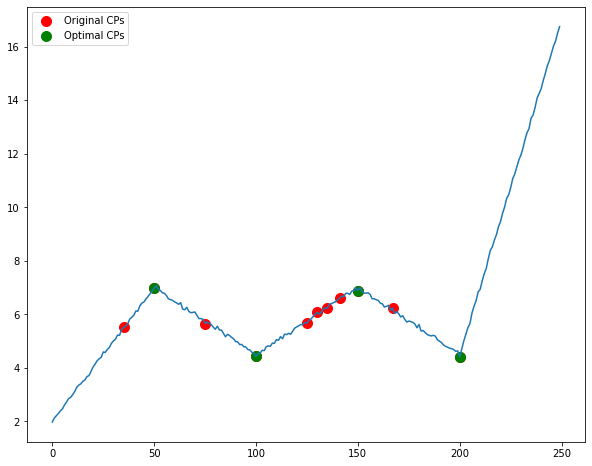

In [188]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(x,y)
ax.scatter(x[true_changepoints],y[true_changepoints],c='r',s=100,label='Original CPs')
ax.scatter(x[optimal_indices[4]],y[optimal_indices[4]],c='g',s=100,label='Optimal CPs')
ax.legend()